In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import largestinteriorrectangle as lir

In [3]:
def generate_convex_polygon(image_size=64, num_points=9):
    # 生成随机点
    points = np.random.randint(0, image_size, (num_points, 2))
    
    # 计算凸包
    hull = ConvexHull(points)
    
    # 返回凸包的顶点
    return points[hull.vertices]

In [5]:
def generate_random_polygon_image(image_size=64, num_points=6):
    # 生成随机的多边形顶点
    points = generate_convex_polygon(image_size, num_points)
    # 创建空白图像
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # 画出多边形
    cv2.fillPoly(image, [points], 255)
    # 返回多边形图像和顶点（在真实问题中，你可能希望返回内接矩形的标签）
    return image, points

In [75]:
# # 展示生成的多边形
# def display_polygon_image():
#     # 生成多边形
#     num_points = np.random.randint(5, 21)
#     print(num_points)
#     image, points = generate_random_polygon_image(image_size=64, num_points=9)
#     rectangle =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
#     rect = np.array([(rectangle[0],rectangle[1]), 
#                      (rectangle[0],rectangle[1]+rectangle[3]-1), 
#                      (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
#                      (rectangle[0]+rectangle[2]-1,rectangle[1])])
#     rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
#     # 显示图像
#     plt.figure(figsize=(5, 5))
#     print(image.shape)
#     plt.imshow(image, cmap='gray')  # 灰度图像
#     plt.plot(rect[:, 0], rect[:, 1], 'r--')
#     # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
#     plt.title('Random Polygon')
#     plt.show()

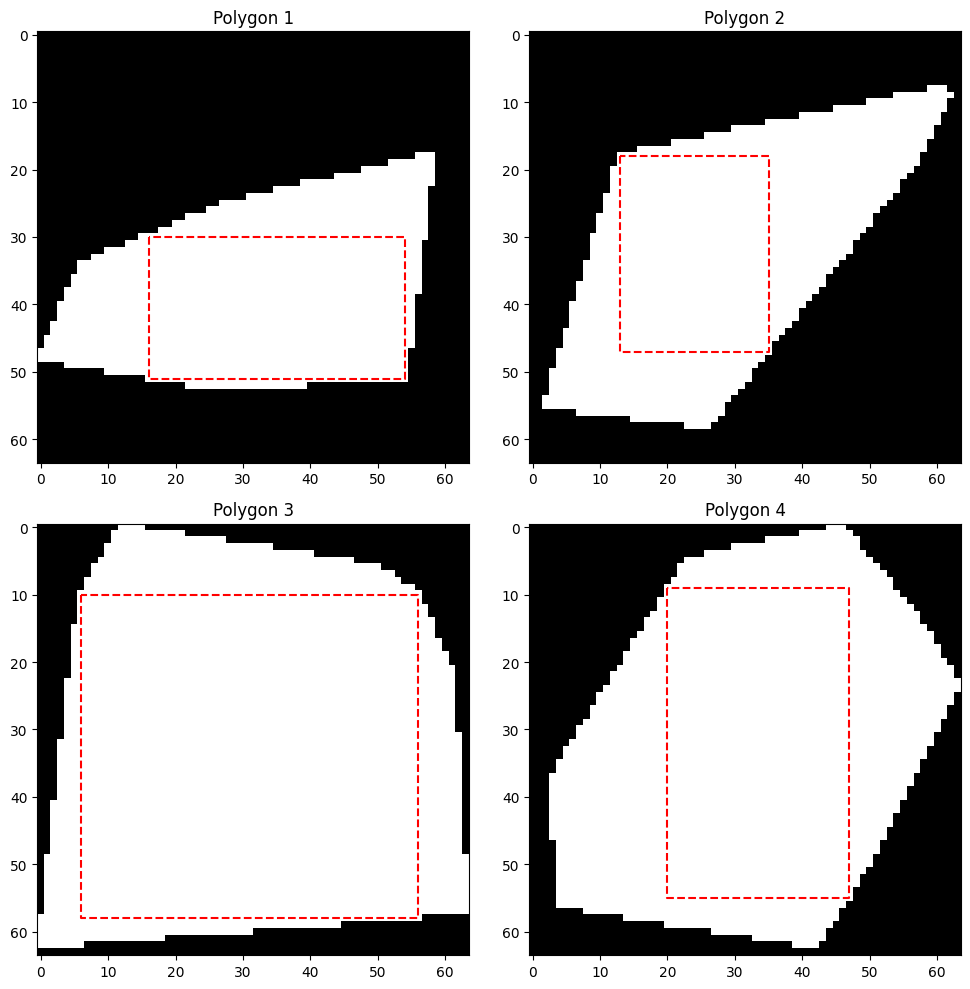

In [140]:
# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    # point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

13
(64, 64)


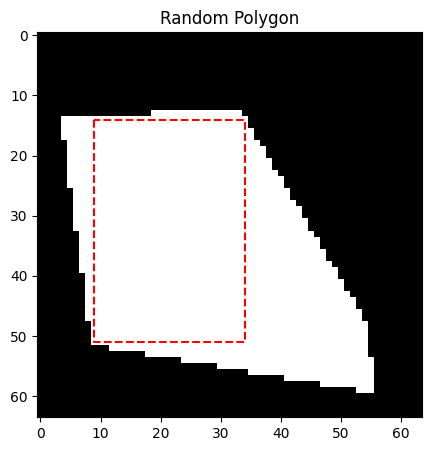

In [41]:
# 生成训练数据 (多边形和最大内接矩形参数)
def generate_training_data(num_samples=1000, image_size=64, point_range=[5,21]) :
    data = []
    for _ in range(num_samples):
        num_points = np.random.randint(point_range[0], point_range[1])
        image, _ = generate_random_polygon_image(image_size=image_size, num_points=9)
        point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
        data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    return data

In [66]:
%%time
import os
import pickle

# 保存为二进制文件
file_path = "data.pkl"
train_data = None
if os.path.exists(file_path):
    print("从文件导入训练数据")
    with open(file_path, 'rb') as file:
        train_data = pickle.load(file)  # 这里应该传递文件对象，而不是文件路径
else:
    print("生成训练数据")
    train_data = generate_training_data(10000)
    with open(file_path, 'wb') as file:
        pickle.dump(train_data, file)

生成训练数据
CPU times: total: 5min 46s
Wall time: 50.2 s


In [69]:
train_data[0:2], len(train_data)

([(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([33, 14, 22, 30], dtype=uint32)),
  (array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([11, 28, 37, 26], dtype=uint32))],
 10000)

In [72]:
# 展示生成的多边形
def display_polygon_image_x(image, rectangle):
    rect = np.array([(rectangle[0],rectangle[1]), 
                     (rectangle[0],rectangle[1]+rectangle[3]-1), 
                     (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
                     (rectangle[0]+rectangle[2]-1,rectangle[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
    # 显示图像
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')  # 灰度图像
    plt.plot(rect[:, 0], rect[:, 1], 'r--')
    # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
    plt.title('Random Polygon')
    plt.show()

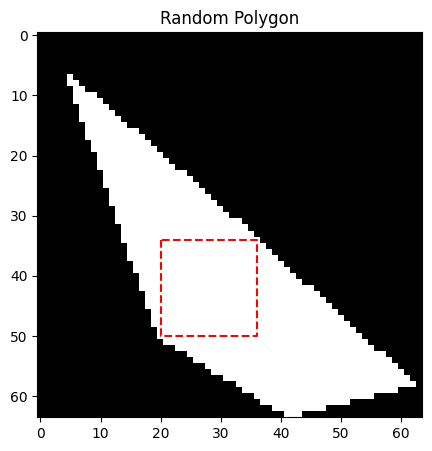

In [96]:
display_polygon_image_x(train_data[4][0].reshape(64,64),train_data[4][1])

In [99]:
dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\loki_\AppData\Local\Temp\ipykernel_6832\596144479.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))


In [130]:
# 简单的全连接神经网络
class RectNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RectNet, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, output_size)
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),       
            nn.LeakyReLU(0.02),
            nn.Dropout(0.5),      # Dropout 层
        
            # 10 filters to 10 filters
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.LeakyReLU(0.02),    
            nn.Dropout(0.3),      # Dropout 层
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        return self.model(x)

In [131]:
len(train_data[0][0])

4096

In [132]:
model = RectNet(input_size=len(train_data[0][0]), output_size=4)

In [133]:
# 优化器 - Adam，学习率为0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器 - 每10个epoch降低学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

In [134]:
# 训练模型
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()  # 训练模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()  # 更新权重
            
            running_loss += loss.item()
        
        # 学习率调度
        scheduler.step()
        
        # 打印每个epoch的平均损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [136]:
train(model, dataloader, criterion, optimizer, scheduler, num_epochs=100)

Epoch [1/100], Loss: 437.1743
Epoch [2/100], Loss: 71.3521
Epoch [3/100], Loss: 34.6114
Epoch [4/100], Loss: 32.1346
Epoch [5/100], Loss: 30.6034
Epoch [6/100], Loss: 30.0599
Epoch [7/100], Loss: 29.6104
Epoch [8/100], Loss: 28.9273
Epoch [9/100], Loss: 28.0320
Epoch [10/100], Loss: 27.7153
Epoch [11/100], Loss: 26.7503
Epoch [12/100], Loss: 26.7295
Epoch [13/100], Loss: 26.2747
Epoch [14/100], Loss: 26.5396
Epoch [15/100], Loss: 26.3377
Epoch [16/100], Loss: 26.3027
Epoch [17/100], Loss: 26.3271
Epoch [18/100], Loss: 26.3617
Epoch [19/100], Loss: 25.9395
Epoch [20/100], Loss: 25.8768
Epoch [21/100], Loss: 26.1700
Epoch [22/100], Loss: 25.4506
Epoch [23/100], Loss: 25.6016
Epoch [24/100], Loss: 25.5016
Epoch [25/100], Loss: 25.5062
Epoch [26/100], Loss: 26.0944
Epoch [27/100], Loss: 25.6248
Epoch [28/100], Loss: 25.3062
Epoch [29/100], Loss: 25.9566
Epoch [30/100], Loss: 25.6436
Epoch [31/100], Loss: 26.1270
Epoch [32/100], Loss: 25.9364
Epoch [33/100], Loss: 26.1678
Epoch [34/100], Lo

In [119]:
num_points = np.random.randint(point_range[0], point_range[1])
testimages, _ = generate_random_polygon_image(image_size=64, num_points=9)

In [ ]:
    rect = np.array([(rectangle[0],rectangle[1]), 
                     (rectangle[0],rectangle[1]+rectangle[3]-1), 
                     (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
                     (rectangle[0]+rectangle[2]-1,rectangle[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
    # 显示图像
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')  # 灰度图像
    plt.plot(rect[:, 0], rect[:, 1], 'r--')
    # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
    plt.title('Random Polygon')
    plt.show()

[12.705392 12.426999 15.473025 23.587208]
[18.194235 12.4028   38.296165 41.92143 ]
[22.285864 23.545593 15.89505  13.650982]
[ 9.461694   7.7945952 35.65291   40.505623 ]


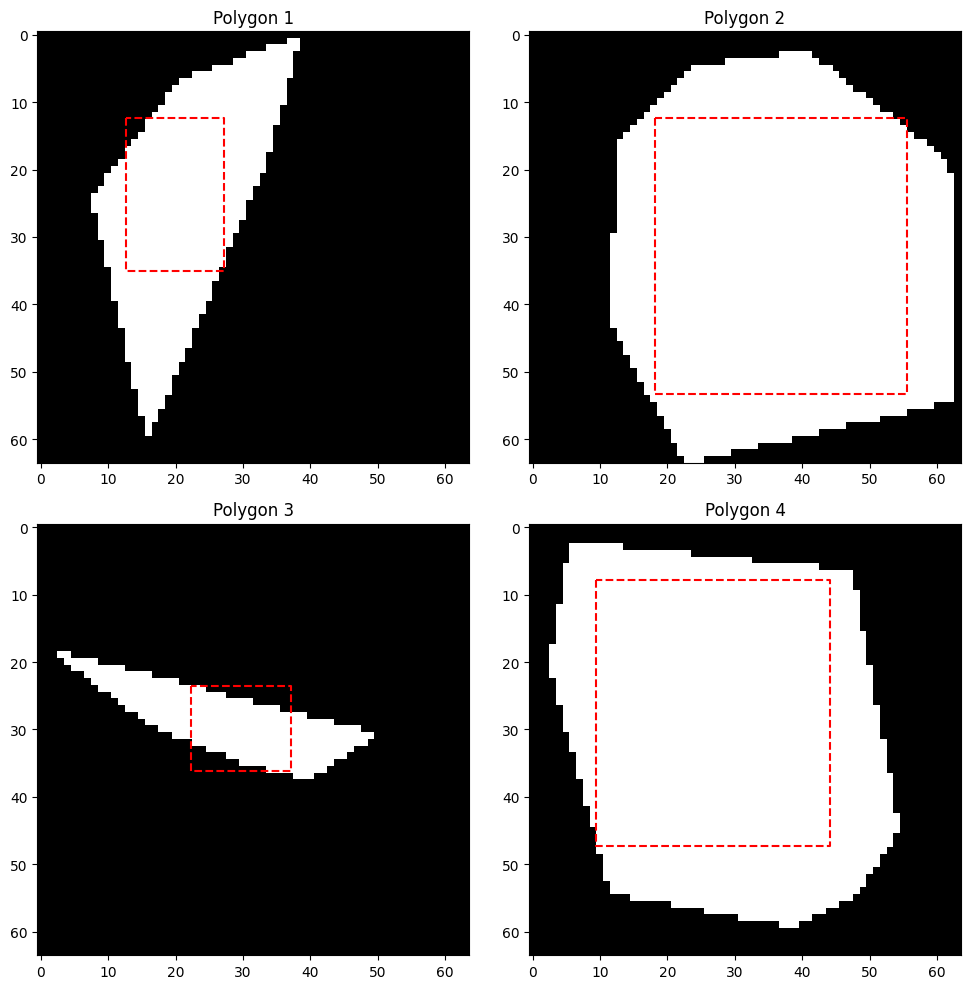

In [142]:
# 生成4个凸多边形
model.eval()

# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    # point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    # data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    with torch.no_grad():
        test_input = torch.tensor(image.flatten(), dtype=torch.float32).unsqueeze(0)
        point = model(test_input).squeeze().numpy()
        print(point)
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [143]:
!pip install nbconvert